In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
# Load the dataset
df = pd.read_excel("Online Retail.xlsx")

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [9]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [10]:
# drop the null rows
df = df.dropna(subset=["CustomerID"])


In [12]:
df = df.dropna(subset=["Description"])

In [13]:
# Look at first few invoice numbers
print(df["InvoiceNo"].head(20))

# Check if any invoice starts with "C"
canceled = df[df["InvoiceNo"].astype(str).str.startswith("C")]
print("Canceled orders:", canceled.shape[0])


0     536365
1     536365
2     536365
3     536365
4     536365
5     536365
6     536365
7     536366
8     536366
9     536367
10    536367
11    536367
12    536367
13    536367
14    536367
15    536367
16    536367
17    536367
18    536367
19    536367
Name: InvoiceNo, dtype: object
Canceled orders: 8905


In [19]:
(df["Quantity"] < 0).sum()

np.int64(8905)

In [23]:
(df["UnitPrice"] <= 0).sum()

np.int64(40)

In [24]:
# 1. Drop missing CustomerID
df = df.dropna(subset=["CustomerID"])

# 2. Remove cancellations (Quantity <= 0)
df = df[df["Quantity"] > 0]

# 3. Remove zero/negative prices
df = df[df["UnitPrice"] > 0]

# 4. Convert CustomerID to integer
df["CustomerID"] = df["CustomerID"].astype(int)

print("Final shape after cleaning:", df.shape)


Final shape after cleaning: (397884, 8)


In [25]:
import datetime as dt

# Find the latest invoice date
latest_date = df["InvoiceDate"].max()

# Snapshot date = one day after last transaction
snapshot_date = latest_date + dt.timedelta(days=1)
print("Snapshot date:", snapshot_date)


Snapshot date: 2011-12-10 12:50:00


In [27]:
# 1. Create TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# 2. Build RFM table
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
})

# 3. Rename columns
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

# Preview RFM table
print(rfm.head())



            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [28]:
# RFM Scoring
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])   # lower recency = better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])


In [29]:
# Combine into one string
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

# Numeric RFM Score (for ranking)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,115,7
12347,2,7,4310.00,5,5,5,555,15
12348,75,4,1797.24,2,4,4,244,10
12349,19,1,1757.55,4,1,4,414,9
12350,310,1,334.40,1,1,2,112,4


In [30]:
def segment_me(row):
    if row["RFM_Score"] >= 12:
        return "Champions"
    elif row["RFM_Score"] >= 9:
        return "Loyal"
    elif row["RFM_Score"] >= 6:
        return "Potential"
    else:
        return "At Risk"

rfm["Segment"] = rfm.apply(segment_me, axis=1)
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,5,115,7,Potential
12347,2,7,4310.00,5,5,5,555,15,Champions
12348,75,4,1797.24,2,4,4,244,10,Loyal
12349,19,1,1757.55,4,1,4,414,9,Loyal
12350,310,1,334.40,1,1,2,112,4,At Risk


In [32]:
segment_summary = rfm.groupby("Segment").agg({
    "Monetary": "sum"
})

segment_summary["Num_Customers"] = rfm.groupby("Segment").size()

segment_summary = segment_summary.rename(columns={
    "Monetary": "Total_Revenue"
})

segment_summary



,Total_Revenue,Num_Customers
Segment,,
At Risk,203424.500,883
Champions,6831550.480,1255
Loyal,1191996.201,1022
Potential,684436.723,1178


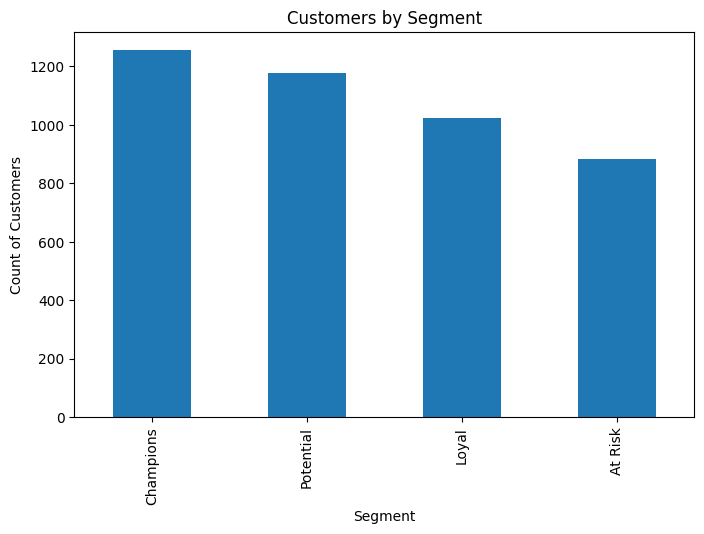

In [33]:
import matplotlib.pyplot as plt

rfm["Segment"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Customers by Segment")
plt.xlabel("Segment")
plt.ylabel("Count of Customers")
plt.show()


In [35]:
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]

In [36]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

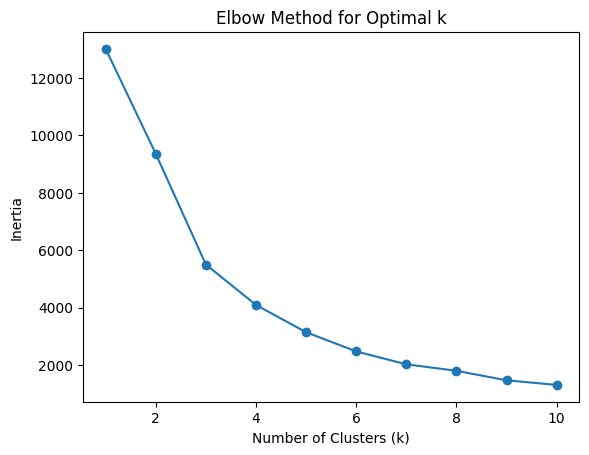

In [37]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [40]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [43]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean'
})
cluster_summary['Num_Customers'] = rfm.groupby('Cluster').size()
cluster_summary

,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,40.983906,4.852677,2012.111620,3231
1,246.023788,1.582800,631.141410,1093
2,7.142857,80.214286,122888.407143,14


In [44]:
rfm.to_csv("rfm_clusters.csv")


In [45]:
# 1. Import
import pickle

# 2. Train KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = rfm[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# 3. Save model + scaler
with open("rfm_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [ ]:
with open("rfm_model.pkl", "rb") as f:
    kmeans = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)


In [47]:
print(kmeans)        # shows k-means model details
print(scaler)        # shows the scaler object
print(kmeans.n_clusters)   # number of clusters


KMeans(n_clusters=3, random_state=42)
StandardScaler()
3


In [48]:
# Example: dummy RFM data (Recency, Frequency, Monetary)
sample = [[50, 10, 5000]]
sample_scaled = scaler.transform(sample)
print("Predicted cluster:", kmeans.predict(sample_scaled))


Predicted cluster: [0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
